# 1. Introduction

This notebook demonstrates how ```bayesic_ode_estimator``` package is used. Note that the package itself has not been released public.

# 2. Background Material

## 2.1 Lotka–Volterra Equations
Lotka–Volterra equations are pairs of first-order nonlinear differential equations, used to describe the dynamics of biological systems in which two species interact, one as a predator and the other as prey.

**Lotka–Volterra**:
$$
    \begin{cases}
      \frac{dx}{dt} = \alpha x - \beta x y \\
      \frac{dy}{dt} = \delta x y - \gamma y
    \end{cases}
$$
  where $x$ = prey, $y$ = predator, $\alpha, \beta, \delta, \gamma$ are positive parameters.

Each parameter is interpreted as:
- $\alpha$: Prey Intrinsic Growth Rate

  rate at which the prey population grows when there are no predators present
- $\beta$: Predation Rate Coefficient

  rate at which predators encounter and consume prey
- $\delta$: Predator Reproduction Rate per Prey Consumed

  rate at which consumed prey are converted into new predators
- $\gamma$: Predator Mortality Rate

  natural death rate of the predator population when there is no food (prey) available


## 2.2 Analytical approach of Lotka–Volterra Equations

If we have observations of $x(t)$ and $y(t)$, we can set up dynamic systems of eqautions:
For each time point $t_i$:
$$\begin{aligned}
\alpha x(t_i) - \beta x(t_i)y(t_i) &\approx \frac{dx}{dt}|_{t=t_i}\\
\delta x(t_i)y(t_i) - \gamma y(t_i) &\approx \frac{dy}{dt}|_{t=t_i}\\
\end{aligned}$$

Where such system can be solved by least-sequares regressoin or other optimization techniques.

However, when dealing with real noisy dataset, directly approximating derivatives at each time point (using finite differences, for instance) can introduce significant errors. This is because noise amplifies the error in numerical differentiation, which then propagates to the parameter estimates.

With such limitation, it is evident that there is a **need for better parameter estimation techniques that can handle noisy data to obtain accurate and stable estimates of the underlying dynamics**.

# 3. Bayesic-ODE-estimator

Alternative to the analytical approach, `Bayesic-ODE-estimator` allows to formulate such problem into parameter estimation problem within a Bayesian framework and employ MCMC sampling methods to approximate the posterior distributions of the Lotka-Volterra paramters. 

By using `Bayesic-ODE-estimator` package, the noisy time-series data of the prey and predator populations are used to construct a likelihood function based on the model's differential equations, while prior distributions are specified for each parameter $\alpha, \beta, \delta, \gamma$. 

This notebook will demonstrate how `Bayesic-ODE-estimator` package uses Metropolis-Hastings MCMC algorithm and generate samples from the posterior, allowing both point estimates and comprehensive quantification of the uncertainty associated with each parameter.

## 3.1 Theoretical Background

Priors, likelihoods, and posteriors are fundamental components in Bayesian inference, and they play a central role in the Metropolis–Hastings algorithm. 
The **prior** represents our initial beliefs about the parameters before observing any data, while the **likelihood** quantifies the probability of the observed data given a set of parameters. Combining these via Bayes’ rule yields the **posterior distribution**, which captures our updated beliefs about the parameters after considering the data. 

The core formula is given by Bayes' rule:
$$p(\theta|y) = \frac{p(y|\theta) p(\theta)}{p(y)}$$
where:

- $p(\theta)$ is the prior, representing our beliefs about the parameter $\theta$ **before** seeing the data.
- $p(y|\theta)$ is the likelihood, quantifying the probability of the data $y$ **given** the parameter $\theta$.
- $p(\theta|y)$ is the posterior, our updated belief about $\theta$ after observing the data.
- $p(y)$ is the evidence, a normalization constant for a proper probability distribution.

In **Metropolis–Hastings**, we are primarily intereseted in sampling from $p(\theta|y)$, and since $p(y)$ does not depend on $\theta$, we can work with the unnormalized posterior:
$$p(\theta|y)\propto p(y|\theta)p(\theta)$$

## 3.2 Applying to Lotka-Volterra Equations

This section will provide a step-by-step guide on how to implement parameter estimation of Lotka-Volterra Equations through `bayesic_ode_estimator`.

In [1]:

import src.bayesic_ode_estimator as bayesic_ode_estimator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 3.2.1 Data Generation

For demonstration purposes, we will create an arbitrary time-series data that incorporates Lotka–Volterra predator–prey model.
Here, we set our true parameters:
$$
        \alpha_{true} = 0.8 \\
        \beta_{true} = 0.04 \\
        \delta_{true} = 0.02 \\
        \gamma_{true} = 0.5
$$

In [2]:
alpha_true, beta_true, delta_true, gamma_true = 0.8, 0.04, 0.02, 0.5
true_params = [alpha_true, beta_true, delta_true, gamma_true]
x0_given, y0_given = 20.0, 10.0

t_eval = np.linspace(0, 100, 100)
sol_true = bayesic_ode_estimator.simulate_lotka_volterra(
    params=true_params,
    t_span=(t_eval[0], t_eval[-1]),
    y0=[x0_given, y0_given],
    t_eval=t_eval
)

lv_clean = sol_true.y.T

np.random.seed(123)
data_observed = lv_clean + np.random.normal(scale=2.0, size=lv_clean.shape)

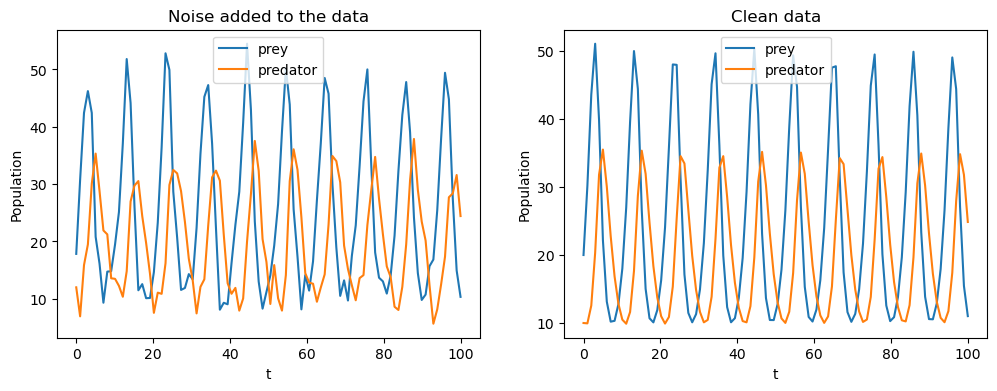

In [3]:
#plot data_observed and lv_clean
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t_eval, data_observed[:, 0], label='prey')
plt.plot(t_eval, data_observed[:, 1], label='predator')
plt.legend()
plt.xlabel('t')
plt.ylabel('Population')
plt.title('Noise added to the data')

plt.subplot(1, 2, 2)
plt.plot(t_eval, lv_clean[:, 0], label='prey')
plt.plot(t_eval, lv_clean[:, 1], label='predator')
plt.legend()
plt.xlabel('t')
plt.ylabel('Population')
plt.title('Clean data')
plt.show()


As the figure on the left shows, it is difficult to estimate the parameter with added noise. 

### 3.2.2 Specification Setup


#### Truncated-Normal Prior

For each parameter $\theta_i$, we use a **truncated-normal prior** defined as:

$$
p(\theta_i) \propto
\begin{cases}
\frac{1}{\sigma_i \, Z_i} \exp\!\Bigl[-\tfrac{1}{2}\Bigl(\frac{\theta_i - \mu_i}{\sigma_i}\Bigr)^2 \Bigr], & \theta_i > 0, \\
0, & \text{otherwise}.
\end{cases}
$$

  This prior encapsulates our initial beliefs about each parameter before observing any data. The truncation ($\theta_i > 0$) ensures that only positive values are considered, which is necessary for parameters representing quantities such as growth or interaction rates in biological models. The parameters $\mu_i$ and $\sigma_i$ represent the mean and standard deviation of our prior belief, respectively.

We set our prior means and standard deviations for the Lotka–Volterra parameters in the following order: 
$\alpha$, $\beta$, $\delta$, $\gamma$
- **Prior Means:** $\mu = [1.0,\, 0.05,\, 0.03,\, 0.6]$
- **Prior Standard Deviations:** $\sigma = [0.1,\, 0.01,\, 0.01,\, 0.1]$

For example, prior distribution of $\alpha \sim \text{TruncNorm} (1, 0.1)$:
$$
p(\alpha) \propto
\begin{cases}
\frac{1}{0.1} \exp\!\left[-\frac{1}{2}\left(\frac{\alpha - 1}{0.1}\right)^2\right], & \alpha > 0, \\
0, & \text{otherwise},
\end{cases}
$$


In [4]:
# Define priors for alpha, beta, delta, gamma
prior_means = [1.0, 0.05, 0.03, 0.6]
prior_sds   = [0.1, 0.01, 0.01, 0.1]
sigma_noise = 10.0

#### Gaussian Likelihood

The **Gaussian likelihood** (assuming known $\sigma$) is expressed in logarithmic form as:

$$
\log p(\text{data} \mid \theta) = -\frac{1}{2\sigma^2}\sum_{t}(x^\text{obs}_t - x^\text{model}_t)^2
- \frac{1}{2\sigma^2}\sum_{t}(y^\text{obs}_t - y^\text{model}_t)^2 
- \frac{N \cdot \log(2\pi\sigma^2)}{2},
$$

where $N$ is the total number of observed points.

  This likelihood function quantifies the probability of the observed data given the model parameters. It assumes that the differences between the observed data and the model predictions are normally distributed with variance $\sigma^2$. The squared differences for both the prey and predator populations are summed, and a normalization constant is included to ensure the likelihood is properly scaled.

#### Posterior Distribution

The **posterior distribution** combines the prior and likelihood using Bayes' rule, and in logarithmic form it is written as:

$$
\log p(\theta \mid \text{data}) = \log p(\theta) + \log p(\text{data}\mid \theta).
$$

  The posterior represents our updated belief about the parameters after incorporating the observed data. By combining the log-prior and log-likelihood, we balance our initial expectations with the evidence provided by the data.


In [5]:
def lv_log_posterior(params):
    return bayesic_ode_estimator.log_posterior_lv(
        params      = params,
        t_eval      = t_eval,
        data        = data_observed,
        x0          = x0_given,
        y0          = y0_given,
        prior_means = prior_means,
        prior_sds   = prior_sds,
        sigma       = sigma_noise

    )

#### Metropolis–Hastings Algorithm

In the **Metropolis–Hastings algorithm**, a new parameter value is proposed using:

$$
\theta^\text{new} = \theta^\text{old} + \epsilon,
$$

where $\epsilon$ is drawn from a normal distribution. The new parameter is accepted with probability:

$$
\min\left(1, \exp\left[\log p(\theta^\text{new}) - \log p(\theta^\text{old})\right]\right).
$$


  This algorithm is used to sample from the posterior distribution. By proposing new values and accepting them based on the change in the log-posterior, the algorithm efficiently explores the parameter space. Higher probability (better fitting) parameters are more likely to be accepted, yet the method also allows for exploration of less probable regions, ensuring a search that avoids local optima.

---

Together, these components form a Bayesian framework for parameter estimation in the Lotka–Volterra model, offering a principled way to incorporate prior knowledge, quantify data uncertainty, and sample from the complex posterior distribution—even in the presence of noise.







In [6]:
MCMC_sampler = bayesic_ode_estimator.MetropolisHastings(
log_posterior_fn = lv_log_posterior

)
result = MCMC_sampler.sample(init_params=prior_means, n_iter=5000, n_chains=4, verbose=True)

Running chain 0...


100%|██████████| 4999/4999 [00:14<00:00, 351.37it/s]


[Chain 0] Acceptance rate: 0.426
Running chain 1...


100%|██████████| 4999/4999 [00:14<00:00, 350.38it/s]


[Chain 1] Acceptance rate: 0.432
Running chain 2...


100%|██████████| 4999/4999 [00:14<00:00, 349.68it/s]


[Chain 2] Acceptance rate: 0.424
Running chain 3...


100%|██████████| 4999/4999 [00:14<00:00, 350.51it/s]

[Chain 3] Acceptance rate: 0.435


In [7]:
posterior_mean, posterior_sd = result.summary()
print(f"Posterior mean of parameter values: {posterior_mean}")
print(f"True parameter values:              {true_params}")

Posterior mean of parameter values: [0.74994144 0.05461466 0.03226747 0.76328186]
True parameter values:              [0.8, 0.04, 0.02, 0.5]


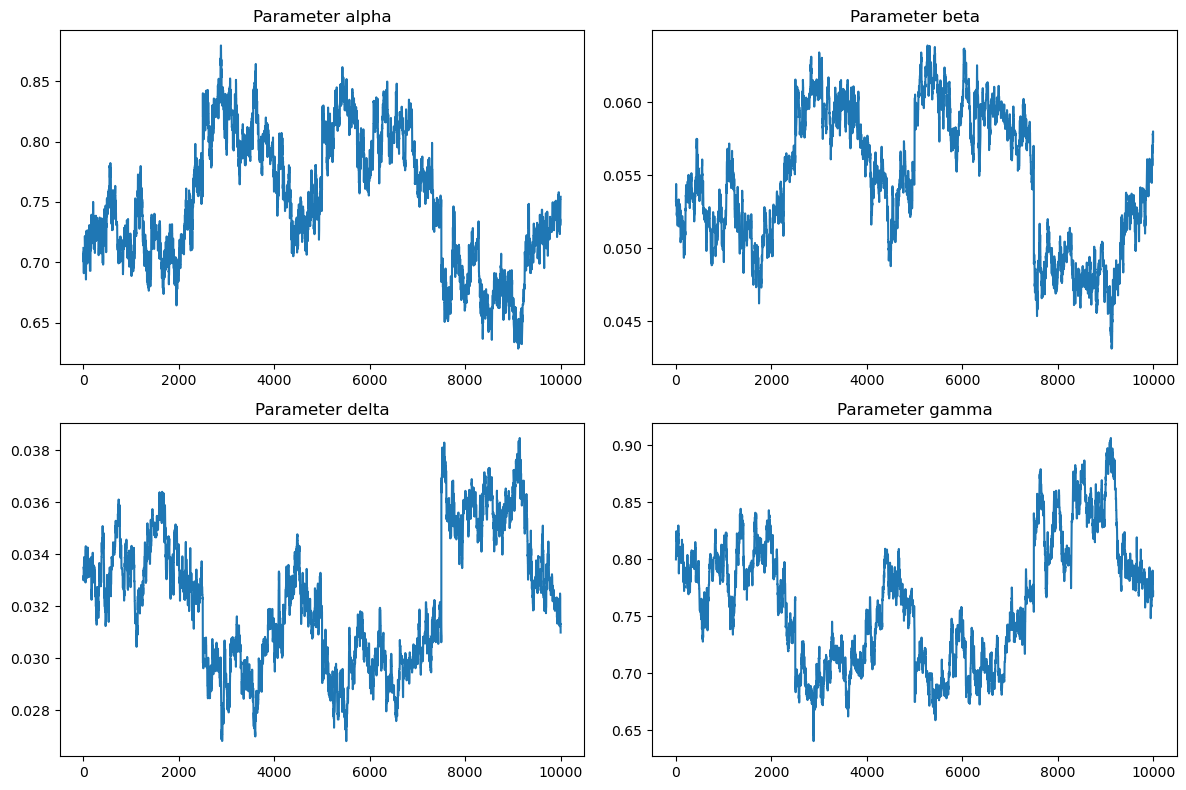

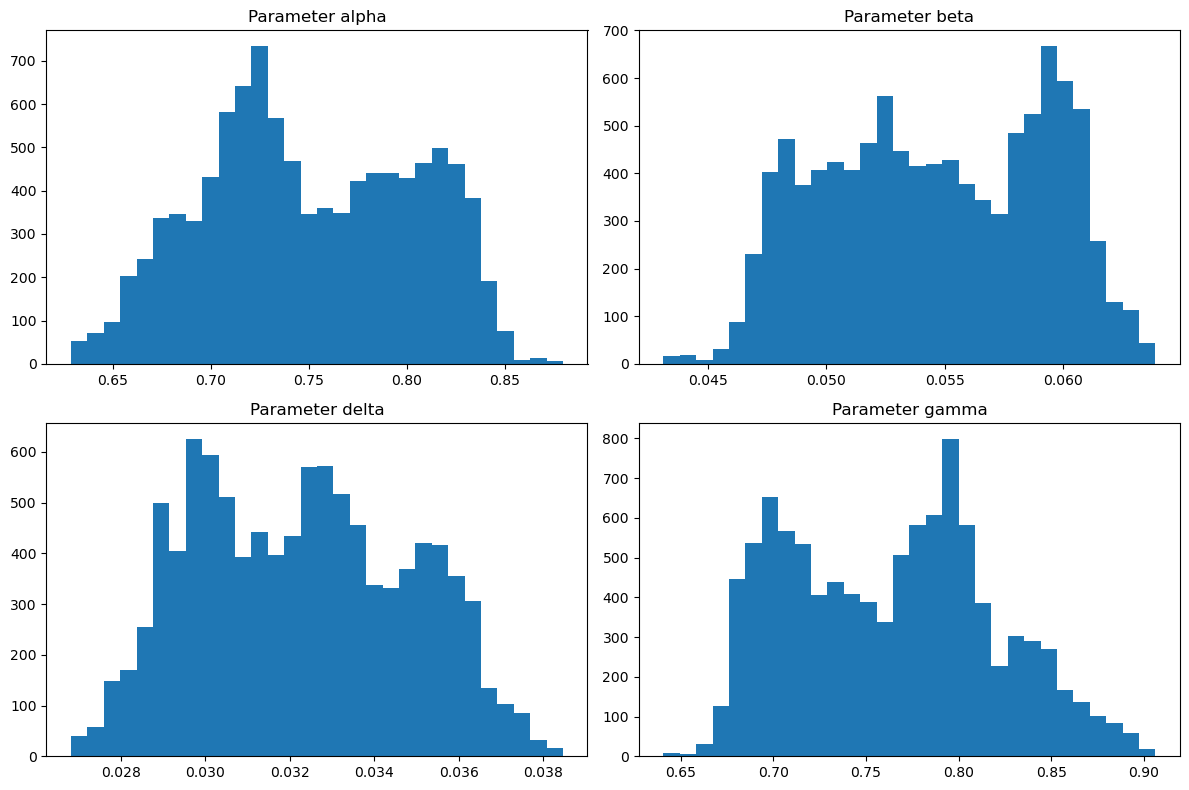

In [9]:
result.visualize(params=['alpha', 'beta', 'delta', 'gamma'])

We can compare the estimated parameters with the true dataset:

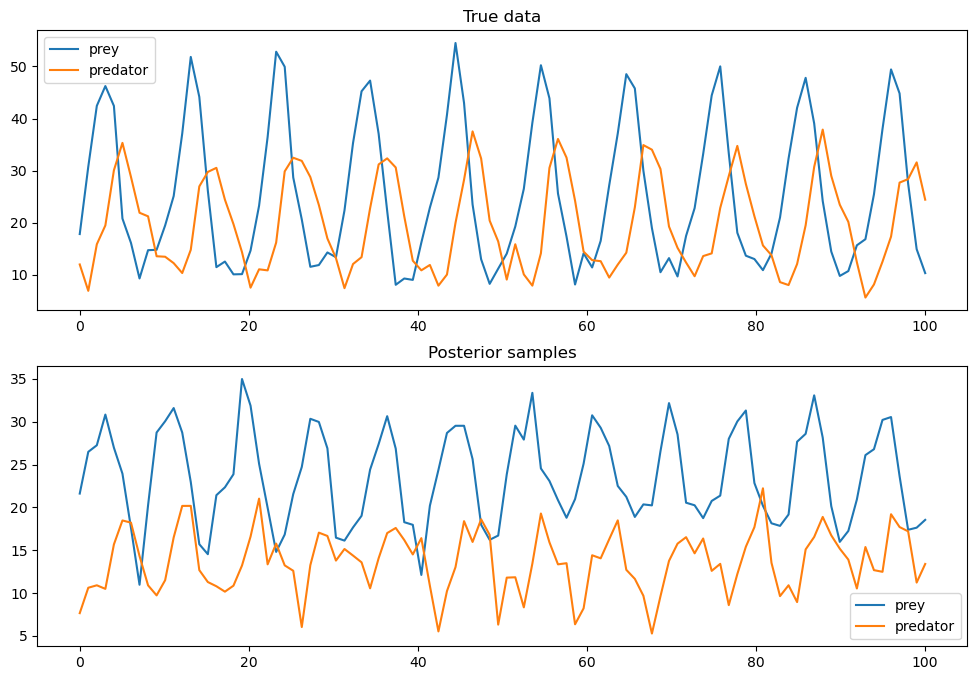

In [10]:
post_alpha, post_beta, post_delta, post_gamma = posterior_mean
post_alpha_sd, post_beta_sd, post_delta_sd, post_gamma_sd = posterior_sd

post_x0, post_y0 = x0_given, y0_given
# try to simulate the model with the posterior mean

sol_post = bayesic_ode_estimator.simulate_lotka_volterra(
    params=[post_alpha, post_beta, post_delta, post_gamma],
    t_span=(t_eval[0], t_eval[-1]),
    y0=[post_x0, post_y0],
    t_eval=t_eval
)

lv_post = sol_post.y.T + np.random.normal(scale=2.0, size=lv_clean.shape)

# plot data_observed vs posterior samples in two plots with titles
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(t_eval, data_observed[:, 0], label='prey')
plt.plot(t_eval, data_observed[:, 1], label='predator')
plt.title("True data")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t_eval, lv_post[:, 0], label='prey')
plt.plot(t_eval, lv_post[:, 1], label='predator')

plt.title("Posterior samples")
plt.legend()
plt.show()

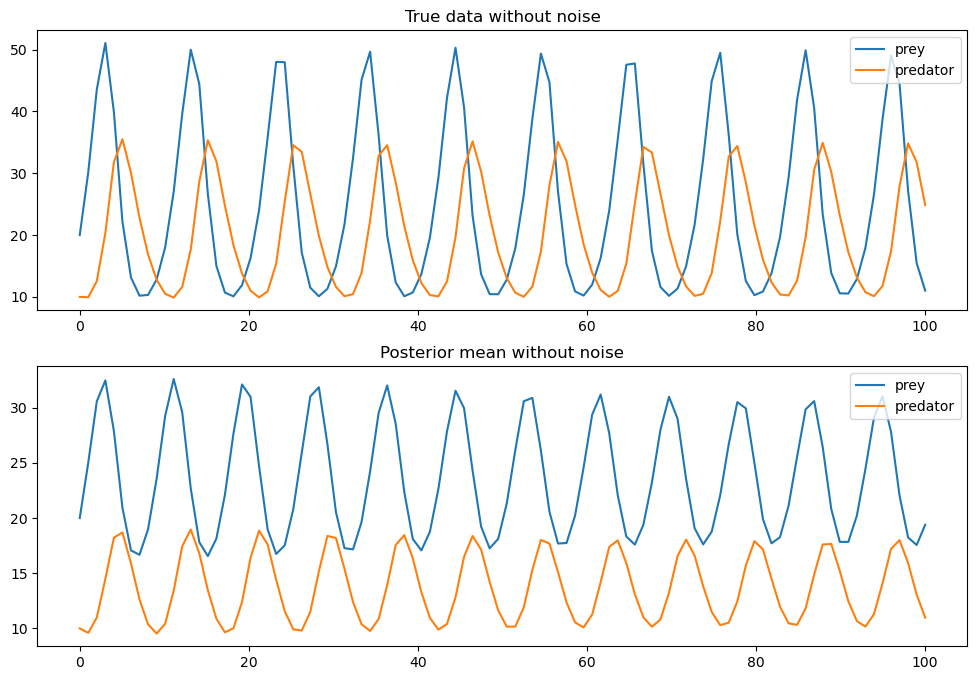

In [11]:
# plot the true data vs the posterior mean
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(t_eval, lv_clean[:, 0], label='prey')
plt.plot(t_eval, lv_clean[:, 1], label='predator')
plt.title("True data without noise")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t_eval, sol_post.y.T[:, 0], label='prey')
plt.plot(t_eval, sol_post.y.T[:, 1], label='predator')
plt.title("Posterior mean without noise")
plt.legend()
plt.show()

Here, we can see that our estimator did not accurately estimate the true parameters. However, this may be because of our naive prior assumption that all parameters follow a truncated normal distribution. By adjusting for a better prior distribution, we may result in a better estimation than the current one.